# MONAI generative image-to-image translation tutorial with ddpm

https://github.com/Project-MONAI/GenerativeModels/blob/main/tutorials/generative/image_to_image_translation/tutorial_segmentation_with_ddpm.ipynb

In [1]:
import os
import tempfile
import time
import seaborn as sns

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from monai import transforms
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader
from monai.utils import set_determinism
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm

from generative.inferers import DiffusionInferer
from generative.networks.nets.diffusion_model_unet import DiffusionModelUNet
from generative.networks.schedulers.ddpm import DDPMScheduler

torch.multiprocessing.set_sharing_strategy('file_system')
print_config()

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


MONAI version: 1.3.1
Numpy version: 1.26.4
Pytorch version: 2.3.1+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 96bfda00c6bd290297f5e3514ea227c6be4d08b4
MONAI __file__: /home/<username>/anaconda3/envs/diffusion/lib/python3.11/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.4.0
Nibabel version: 5.2.1
scikit-image version: 0.24.0
scipy version: 1.13.1
Pillow version: 10.3.0
Tensorboard version: 2.17.0
gdown version: 5.2.0
TorchVision version: 0.18.1+cu121
tqdm version: 4.66.4
lmdb version: 1.5.1
psutil version: 5.9.8
pandas version: 2.2.2
einops version: 0.8.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: 2.14.1
pynrrd version: 1.0.0
clearml version: 1.16.2

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [2]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory

In [3]:
set_determinism(2650)

In [4]:
device = torch.device("cuda:3")

## Data

In [5]:
channel = 0  # 0 = Flair
assert channel in [0, 1, 2, 3], "Choose a valid channel"  # 유효한 채널을 선택했는지 확인

train_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image", "label"]),  # "image"와 "label" 데이터를 로드
        transforms.EnsureChannelFirstd(keys=["image", "label"]),  # "image"와 "label"의 채널을 첫 번째 차원으로 설정
        transforms.Lambdad(keys=["image"], func=lambda x: x[channel, :, :, :]),  # 선택한 채널의 데이터를 추출
        transforms.EnsureChannelFirstd(keys=["image"], channel_dim="no_channel"),  # 채널 차원을 첫 번째로 설정
        transforms.EnsureTyped(keys=["image", "label"]),  # "image"와 "label"의 타입을 보장
        transforms.Orientationd(keys=["image", "label"], axcodes="RAS"),  # 이미지를 RAS(우측-앞-위) 방향으로 정렬
        transforms.Spacingd(keys=["image", "label"], pixdim=(3.0, 3.0, 2.0),
                            mode=("bilinear", "nearest")),  # 이미지의 해상도를 지정된 픽셀 크기로 재조정
        transforms.CenterSpatialCropd(keys=["image", "label"], roi_size=(64, 64, 64)),  # 이미지의 중심에서 64x64x64 크기로 자르기
        transforms.ScaleIntensityRangePercentilesd(
            keys="image", lower=0, upper=99.5, b_min=0, b_max=1),  # 이미지의 강도를 0에서 99.5 퍼센타일 범위로 스케일링
        transforms.RandSpatialCropd(keys=["image", "label"], roi_size=(64, 64, 1),
                                    random_size=False),  # 랜덤하게 64x64x1 크기로 자르기
        transforms.Lambdad(keys=["image", "label"], func=lambda x: x.squeeze(-1)),  # 마지막 차원을 제거
    ]
)

In [6]:
DATA_DIR = '../../../../mnt/sda/suhohan/BraTS2020'

In [7]:
batch_size = 200
num_workers = 8
train_ds = DecathlonDataset(
    root_dir=DATA_DIR,
    task="Task01_BrainTumour",
    section="training",
    cache_rate=1.0,
    num_workers=8,
    download=False,
    seed=0,
    transform=train_transforms,
)

print(f"Length of training data: {len(train_ds)}")  # this gives the number of patients in the training set
print(f'Train image shape {train_ds[0]["image"].shape}')
print(f'Train label shape {train_ds[0]["label"].shape}')


train_loader = DataLoader(
    train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True, persistent_workers=True
)

Loading dataset: 100%|██████████| 388/388 [01:52<00:00,  3.44it/s]

Length of training data: 388
Train image shape torch.Size([1, 64, 64])
Train label shape torch.Size([1, 64, 64])


In [8]:
val_ds = DecathlonDataset(
    root_dir=DATA_DIR,
    task="Task01_BrainTumour",
    section="validation",
    cache_rate=1.0,  # you may need a few Gb of RAM... Set to 0 otherwise
    num_workers=4,
    download=False,  # Set download to True if the dataset hasnt been downloaded yet
    seed=0,
    transform=train_transforms,
)
print(f"Length of training data: {len(val_ds)}")
print(f'Validation Image shape {val_ds[0]["image"].shape}')
print(f'Validation Label shape {val_ds[0]["label"].shape}')

val_loader = DataLoader(
    val_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=True, persistent_workers=True
)

Loading dataset: 100%|██████████| 96/96 [00:31<00:00,  3.09it/s]

Length of training data: 96
Validation Image shape torch.Size([1, 64, 64])
Validation Label shape torch.Size([1, 64, 64])


In [9]:
model = DiffusionModelUNet(
    spatial_dims=2,
    in_channels=2,
    out_channels=1,
    num_channels=(64, 64, 64),
    attention_levels=(False, False, True),
    num_res_blocks=1,
    num_head_channels=64,
    with_conditioning=False,
)
model.to(device)

DiffusionModelUNet(
  (conv_in): Convolution(
    (conv): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (time_embed): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): SiLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
  )
  (down_blocks): ModuleList(
    (0-1): 2 x DownBlock(
      (resnets): ModuleList(
        (0): ResnetBlock(
          (norm1): GroupNorm(32, 64, eps=1e-06, affine=True)
          (nonlinearity): SiLU()
          (conv1): Convolution(
            (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (time_emb_proj): Linear(in_features=256, out_features=64, bias=True)
          (norm2): GroupNorm(32, 64, eps=1e-06, affine=True)
          (conv2): Convolution(
            (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (skip_connection): Identity()
        )
      )
      (downsampler): Downsample(
       

In [10]:
scheduler = DDPMScheduler(num_train_timesteps=1000)
optimizer = torch.optim.Adam(params=model.parameters(), lr=2.5e-5)
inferer = DiffusionInferer(scheduler)

## Training

In [15]:
n_epochs = 1000
val_interval = 50
epoch_loss_list = []
val_epoch_loss_list = []

In [16]:
scaler = GradScaler()
total_start = time.time()

for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0

    for step, data in enumerate(train_loader):
        images = data["image"].to(device)
        seg = data["label"].to(device)  # this is the ground truth segmentation
        optimizer.zero_grad(set_to_none=True)
        timesteps = torch.randint(0, 1000, (len(images),)).to(device)  # pick a random time step t

        with autocast(enabled=True):
            # Generate random noise
            noise = torch.randn_like(seg).to(device)
            noisy_seg = scheduler.add_noise(
                original_samples=seg, noise=noise, timesteps=timesteps
            )  # we only add noise to the segmentation mask
            combined = torch.cat(
                (images, noisy_seg), dim=1
            )  # we concatenate the brain MR image with the noisy segmenatation mask, to condition the generation process
            prediction = model(x=combined, timesteps=timesteps)
            # Get model prediction
            loss = F.mse_loss(prediction.float(), noise.float())
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()

    epoch_loss_list.append(epoch_loss / (step + 1))
    if (epoch) % val_interval == 0:
        model.eval()
        val_epoch_loss = 0
        for step, data_val in enumerate(val_loader):
            images = data_val["image"].to(device)
            seg = data_val["label"].to(device)  # this is the ground truth segmentation
            timesteps = torch.randint(0, 1000, (len(images),)).to(device)
            with torch.no_grad():
                with autocast(enabled=True):
                    noise = torch.randn_like(seg).to(device)
                    noisy_seg = scheduler.add_noise(original_samples=seg, noise=noise, timesteps=timesteps)
                    combined = torch.cat((images, noisy_seg), dim=1)
                    prediction = model(x=combined, timesteps=timesteps)
                    val_loss = F.mse_loss(prediction.float(), noise.float())
            val_epoch_loss += val_loss.item()
        print("Epoch", epoch, "Validation loss", val_epoch_loss / (step + 1))
        val_epoch_loss_list.append(val_epoch_loss / (step + 1))

torch.save(model.state_dict(), "./segmodel.pt")
total_time = time.time() - total_start
print(f"train diffusion completed, total time: {total_time}.")

Epoch 0 Validation loss 0.0
Epoch 50 Validation loss 0.0
Epoch 100 Validation loss 0.0
Epoch 150 Validation loss 0.0
Epoch 200 Validation loss 0.0
Epoch 250 Validation loss 0.0
Epoch 300 Validation loss 0.0
Epoch 350 Validation loss 0.0
Epoch 400 Validation loss 0.0
Epoch 450 Validation loss 0.0
Epoch 500 Validation loss 0.0
Epoch 550 Validation loss 0.0
Epoch 600 Validation loss 0.0
Epoch 650 Validation loss 0.0
Epoch 700 Validation loss 0.0
Epoch 750 Validation loss 0.0
Epoch 800 Validation loss 0.0
Epoch 850 Validation loss 0.0
Epoch 900 Validation loss 0.0
Epoch 950 Validation loss 0.0
train diffusion completed, total time: 580.6447968482971.


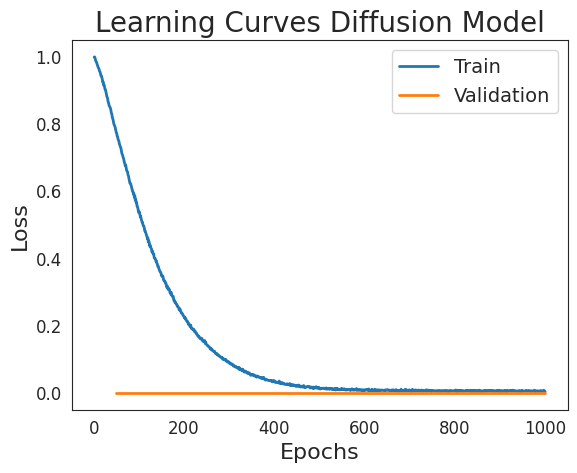

In [17]:
sns.set_style("white")

plt.title("Learning Curves Diffusion Model", fontsize=20)
plt.plot(np.linspace(1, n_epochs, n_epochs), epoch_loss_list, color="C0", linewidth=2.0, label="Train")
plt.plot(
    np.linspace(val_interval, n_epochs, int(n_epochs / val_interval)),
    val_epoch_loss_list,
    color="C1",
    linewidth=2.0,
    label="Validation",
)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.legend(prop={"size": 14})
plt.show()

## Sampling 

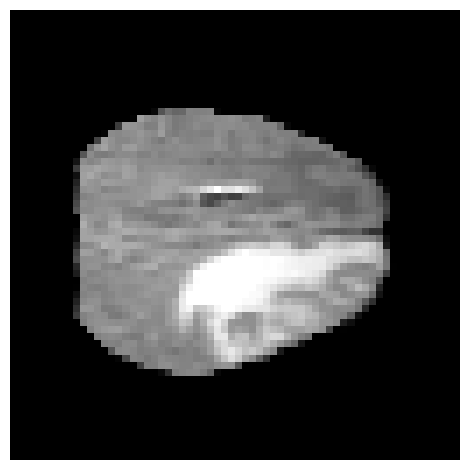

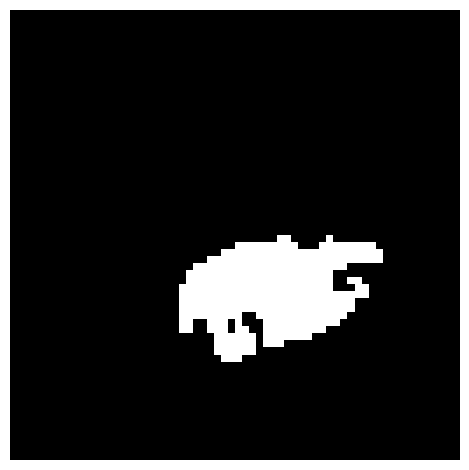

DiffusionModelUNet(
  (conv_in): Convolution(
    (conv): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (time_embed): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): SiLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
  )
  (down_blocks): ModuleList(
    (0-1): 2 x DownBlock(
      (resnets): ModuleList(
        (0): ResnetBlock(
          (norm1): GroupNorm(32, 64, eps=1e-06, affine=True)
          (nonlinearity): SiLU()
          (conv1): Convolution(
            (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (time_emb_proj): Linear(in_features=256, out_features=64, bias=True)
          (norm2): GroupNorm(32, 64, eps=1e-06, affine=True)
          (conv2): Convolution(
            (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (skip_connection): Identity()
        )
      )
      (downsampler): Downsample(
       

In [18]:
idx = 0
data = val_ds[idx]
inputimg = data["image"][0, ...]  # Pick an input slice of the validation set to be segmented
inputlabel = data["label"][0, ...]  # Check out the ground truth label mask. If it is empty, pick another input slice.


plt.figure("input" + str(inputlabel))
plt.imshow(inputimg, vmin=0, vmax=1, cmap="gray")
plt.axis("off")
plt.tight_layout()
plt.show()

plt.figure("input" + str(inputlabel))
plt.imshow(inputlabel, vmin=0, vmax=1, cmap="gray")
plt.axis("off")
plt.tight_layout()
plt.show()


model.eval()

100%|██████████| 1000/1000 [00:12<00:00, 79.68it/s]


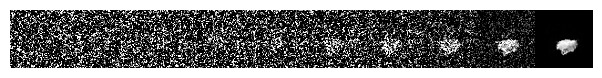

100%|██████████| 1000/1000 [00:12<00:00, 82.64it/s]


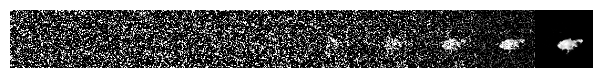

100%|██████████| 1000/1000 [00:12<00:00, 81.51it/s]


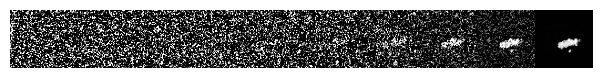

100%|██████████| 1000/1000 [00:12<00:00, 81.51it/s]


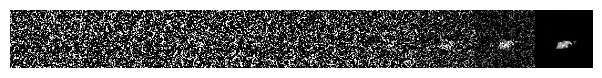

100%|██████████| 1000/1000 [00:12<00:00, 80.26it/s]


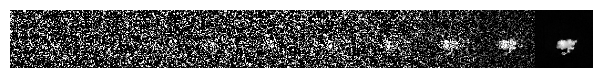

In [19]:
n = 5
input_img = inputimg[None, None, ...].to(device)
ensemble = []
for k in range(5):
    noise = torch.randn_like(input_img).to(device)
    current_img = noise  # for the segmentation mask, we start from random noise.
    combined = torch.cat(
        (input_img, noise), dim=1
    )  # We concatenate the input brain MR image to add anatomical information.

    scheduler.set_timesteps(num_inference_steps=1000)
    progress_bar = tqdm(scheduler.timesteps)
    chain = torch.zeros(current_img.shape)
    for t in progress_bar:  # go through the noising process
        with autocast(enabled=False):
            with torch.no_grad():
                model_output = model(combined, timesteps=torch.Tensor((t,)).to(current_img.device))
                current_img, _ = scheduler.step(
                    model_output, t, current_img
                )  # this is the prediction x_t at the time step t
                if t % 100 == 0:
                    chain = torch.cat((chain, current_img.cpu()), dim=-1)
                combined = torch.cat(
                    (input_img, current_img), dim=1
                )  # in every step during the denoising process, the brain MR image is concatenated to add anatomical information

    plt.style.use("default")
    plt.imshow(chain[0, 0, ..., 64:].cpu(), vmin=0, vmax=1, cmap="gray")
    plt.tight_layout()
    plt.axis("off")
    plt.show()
    ensemble.append(current_img)  # this is the output of the diffusion model after T=1000 denoising steps

## Prediction

In [20]:
def dice_coeff(im1, im2, empty_score=1.0):
    im1 = np.asarray(im1).astype(bool)
    im2 = np.asarray(im2).astype(bool)

    im_sum = im1.sum() + im2.sum()
    if im_sum == 0:
        return empty_score

    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)

    return 2.0 * intersection.sum() / im_sum

Dice score of sample0 0.793418647166362
Dice score of sample1 0.7392996108949417
Dice score of sample2 0.614406779661017
Dice score of sample3 0.37468354430379747
Dice score of sample4 0.680161943319838
Dice score on the mean map 0.6625


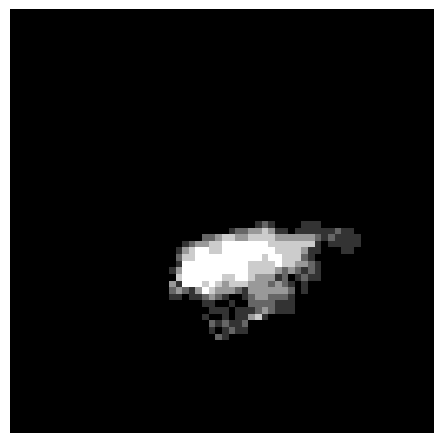

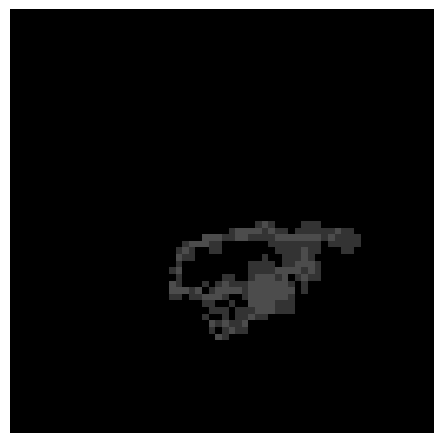

In [22]:
for i in range(len(ensemble)):
    prediction = torch.where(ensemble[i] > 0.5, 1, 0).float()  # a binary mask is obtained via thresholding
    # plt.imshow(prediction[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")  # We plot the mean map
    # plt.tight_layout()
    # plt.axis("off")
    # plt.show()
    score = dice_coeff(
        prediction[0, 0].cpu(), inputlabel.cpu()
    )  # we compute the dice scores for all samples separately
    print("Dice score of sample" + str(i), score)


E = torch.where(torch.cat(ensemble) > 0.5, 1, 0).float()
var = torch.var(E, dim=0)  # pixel-wise variance map over the ensemble
mean = torch.mean(E, dim=0)  # pixel-wise mean map over the ensemble
mean_prediction = torch.where(mean > 0.5, 1, 0).float()

score = dice_coeff(mean_prediction[0, ...].cpu(), inputlabel.cpu())  # Here we predict the Dice score for the mean map
print("Dice score on the mean map", score)

plt.style.use("default")
plt.imshow(mean[0, ...].cpu(), vmin=0, vmax=1, cmap="gray")  # We plot the mean map
plt.tight_layout()
plt.axis("off")
plt.show()
plt.style.use("default")
plt.imshow(var[0, ...].cpu(), vmin=0, vmax=1, cmap="gray")  # We plot the variance map
plt.tight_layout()
plt.axis("off")
plt.show()